# Algoritmo de Deutsh-Jozsa

In [3]:
# Importamos las librerias necesarias

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram, plot_state_qsphere
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt

La siguiente función implementa un algoritmo "phase oracle"  aplicar una transformación unitaria $U_f$ al estado $|\psi_1\rangle$. Recordemos que, $U|x\rangle = \lambda_x |x\rangle $, donde $\lambda_x$ tiene la forma $e^{i\theta}$. Este tipo de operaciones se conoce como una "phase oracle" o caja negra.

La operación de un "phase oracle" puede expresarse matemáticamente como:

$$
|x\rangle \to (-1)^{f(x)} |x\rangle
$$

- Si $ f(x) = 0 $, el estado permanece inalterado.
- Si $ f(x) = 1 $, se introduce una fase de $-1$.

**Fase Cuántica**

En computación cuántica, la fase de un estado afecta cómo interactúa con otros estados durante las operaciones. Aunque un cambio de fase no es observable directamente al medir un estado, tiene un impacto crucial cuando se combina con operaciones como las puertas Hadamard, generando **interferencia cuántica**.

Por ejemplo:
$$
|0\rangle + |1\rangle \quad \text{y} \quad |0\rangle - |1\rangle
$$
son estados diferentes que pueden producir resultados opuestos dependiendo de la operación aplicada.

---

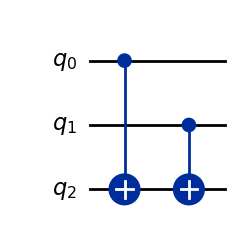

In [4]:
# Ejemplo de construcción de circuitos cuánticos
nbits = 2
oracle_circuit = QuantumCircuit(nbits + 1)
for qubit in range(nbits):
        oracle_circuit.cx(qubit, nbits)

oracle_circuit.draw(output='mpl')

In [5]:
def deutsch_jozsa_oracle(nbits, f_type="constant", constant_value=0):
    """
    Crea un oráculo cuántico simple para Deutsch-Jozsa.
    Args:
        nbits (int): Número de qubits de entrada del oráculo.
        f_type (str): Tipo de función. Puede ser "constant" o "balanced".
        constant_value (int): Si f_type="constant", define si f(x) = 0 o f(x) = 1.
    Returns:
        QuantumCircuit: Circuito cuántico que representa el oráculo.
    """
    oracle_circuit = QuantumCircuit(nbits + 1, name="Oracle")

    if f_type == "constant":
        if constant_value == 1:
            # Si f(x) = 1, invertir el qubit auxiliar
            oracle_circuit.x(nbits)
    elif f_type == "balanced":
        # Si es balanceada, aplicar CX entre cada qubit de entrada y el qubit auxiliar
        for qubit in range(nbits):
            oracle_circuit.cx(qubit, nbits)
    else:
        raise ValueError("f_type debe ser 'constant' o 'balanced'.")

    return oracle_circuit


Vamos a inicializar un estado $|\psi_0\rangle$ de la siguiente forma:
$$
|\psi_0\rangle = |00...01\rangle =|0\rangle^{\otimes n} |1\rangle
$$
Como segundo paso vamos a una puerta Hadamard sobre el estado $|\psi_0\rangle $

$$
    |\psi_1\rangle = H^{\otimes n} |\psi_0\rangle = \frac{1}{\sqrt{2^n}} \sum_{x \in \{ 0,1\}^n} (-1)^{x \cdot \psi_0 } |x\rangle \left[\frac{|0\rangle - |1\rangle}{\sqrt{2}} \right].
$$

El siguiente paso implica aplicar la oparación unitaria $U_f$ a todos los qubits, 

$$
|\psi_2\rangle = U_f |\psi_1\rangle = \frac{1}{\sqrt{2^n}} \sum_{x \in \{ 0,1\}^n} U_f|x\rangle = \frac{1}{\sqrt{2^n}} \sum_{x \in \{ 0,1\}^n} (-1)^{f(x)}|x\rangle\left[\frac{|0\rangle - |1\rangle}{\sqrt{2}} \right].
$$

Luego aplicamos la compuerta $H$,

$$
|\psi_3\rangle = H^{\otimes n}|\psi_2\rangle = \frac{1}{\sqrt{2^n}} \sum_{x \in \{ 0,1\}^n} (-1)^{f(x)} H^{\otimes n} |x\rangle
$$

ahora bien,

$$
H^{\otimes n} |x\rangle = \frac{1}{\sqrt{2^n}} \sum_{k \in \{ 0,1\}^n}(-1)^{x \cdot k}|k\rangle
$$

Considerando este último resultado, 

$$
|\psi_3\rangle = \sum_{k \in \{ 0,1\}^n} \left[ \frac{1}{2^n} \sum_{x \in \{ 0,1\}^n} (-1)^{f(x) + x \cdot k} \right] |k\rangle
$$

lo que resulta en:
$$
|\psi_3\rangle = \sum_{k \in \{ 0,1\}^n} c_k |k\rangle
$$

Nuestro estado final está dado por $|\psi_3\rangle$ y solo nos quedaria realizar la medida. 

Circuito del Oráculo:


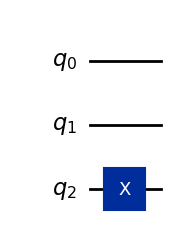

In [6]:
# Crear el oráculo con f(x)
oracle_gate = deutsch_jozsa_oracle(2, f_type="constant", constant_value=1)

# Graficar el circuito
print("Circuito del Oráculo:")
oracle_gate.draw("mpl")

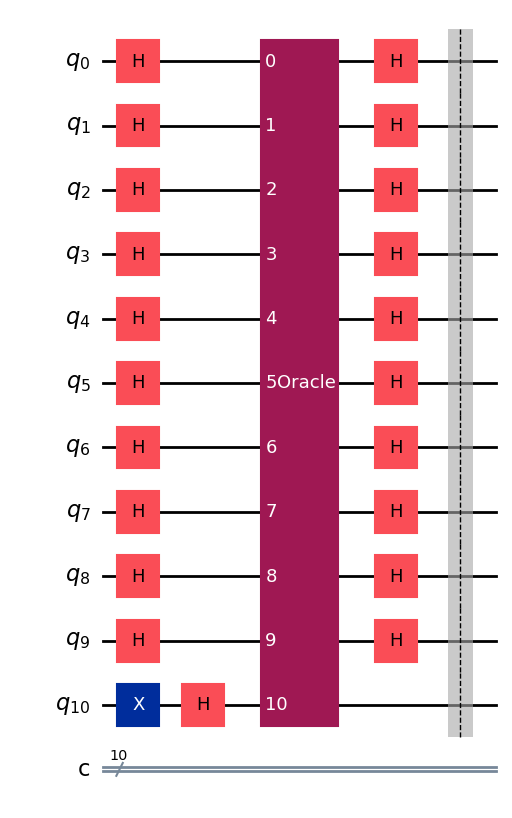

In [7]:
# Numero de bits de entrada
n = 10

# Creamos los registros cuánticos y clásicos
qr = QuantumRegister(n+1, 'q')
cr = ClassicalRegister(n, 'c')

# Paso 1 : Preparar el estado inicial
qc = QuantumCircuit(qr, cr)
qc.h(range(n))      # Aplicar H a los qubits de entrada
qc.x(n)             # Aplicar X al qubit auxiliar
qc.h(n)             # Aplicar H al qubit auxiliar

# Paso 2: Aplicar el oráculo
oracle_gate = deutsch_jozsa_oracle(nbits=n, f_type="constant", constant_value=0)
qc.append(oracle_gate, qr)

# Paso 3: Aplicar H a los qubits de entrada
qc.h(range(n))

qc.barrier()
qc.draw(output='mpl')

Medir los qbits de entrada

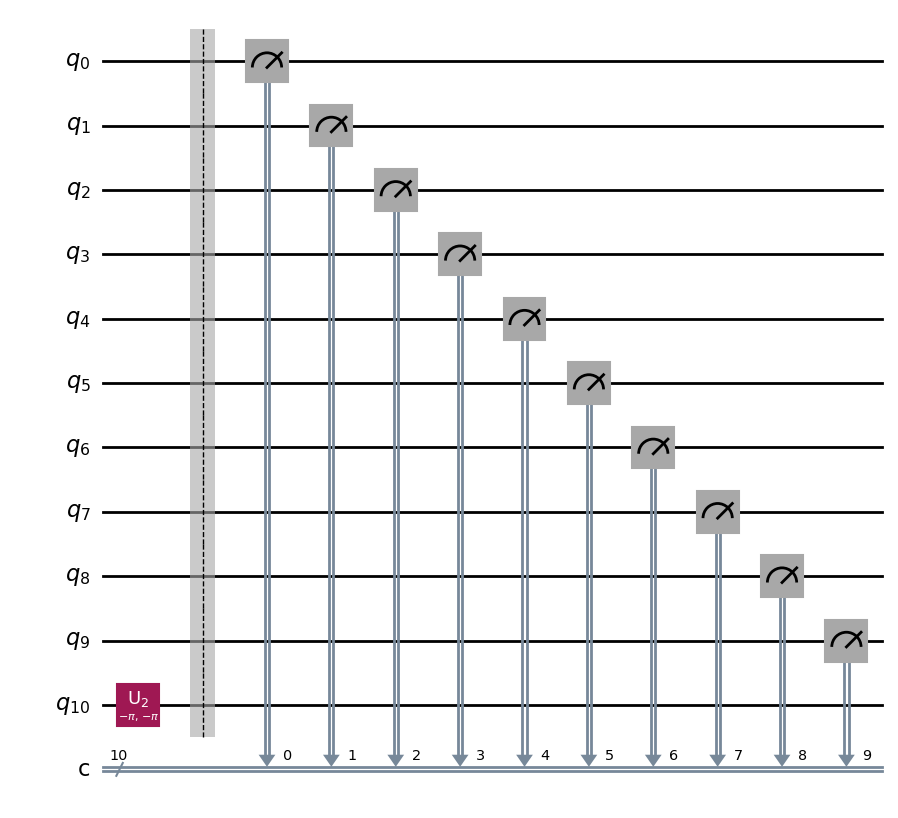

In [8]:
# Paso 4: Medir los qubits de entrada
qc.measure(range(n), range(n))

# Creamos el simulador cuántico
qasm_simulator = Aer.get_backend('qasm_simulator')

# Transpilamos el circuito para el backend
transpiled_qc = transpile(qc, qasm_simulator)
transpiled_qc.draw(output='mpl')    


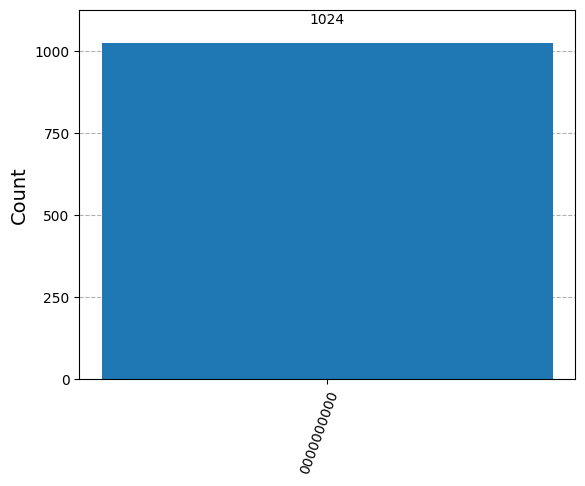

In [9]:

job = qasm_simulator.run(transpiled_qc, shots=1024)
result = job.result()

# Mostramos el histograma con los resultados
counts = result.get_counts()
plot_histogram(counts)

# Vamos a repetir en el hardware cuántico

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler, EstimatorV2 as Estimator
from qiskit.transpiler import generate_preset_pass_manager

service = QiskitRuntimeService()

# Caso Balanceado

Usando el backend: ibm_kyiv


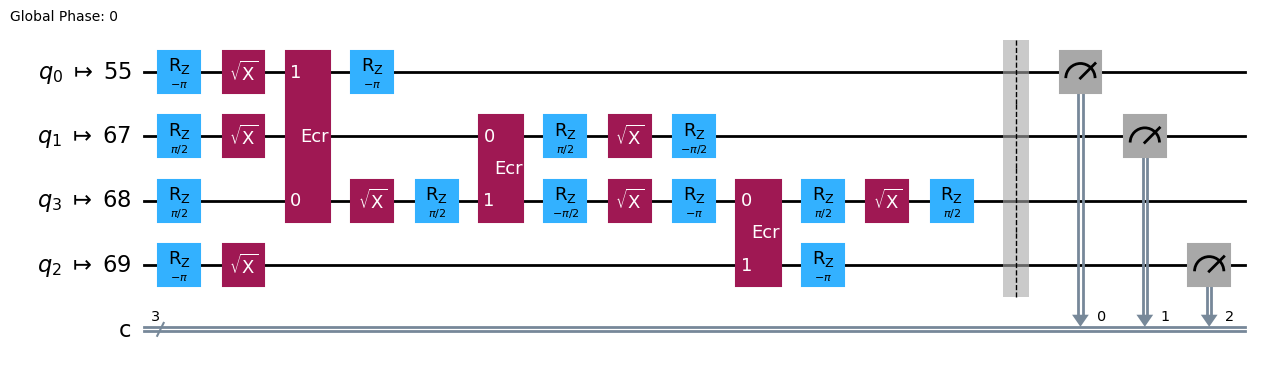

In [28]:
# Numero de bits de entrada
n = 3

# Creamos los registros cuánticos y clásicos
qr = QuantumRegister(n+1, 'q')
cr = ClassicalRegister(n, 'c')

# Paso 1 : Preparar el estado inicial
qc = QuantumCircuit(qr, cr)
qc.h(range(n))      # Aplicar H a los qubits de entrada
qc.x(n)             # Aplicar X al qubit auxiliar
qc.h(n)             # Aplicar H al qubit auxiliar

# Paso 2: Aplicar el oráculo
oracle_gate = deutsch_jozsa_oracle(nbits=n, f_type="balanced", constant_value=0)
qc.append(oracle_gate, qr)

# Paso 3: Aplicar H a los qubits de entrada
qc.h(range(n))
qc.barrier()

# Paso 4: Medir los qubits de entrada
qc.measure(range(n), range(n))

# definimos el backend
backend = service.least_busy(simulator= False, operational=True)
print(f"Usando el backend: {backend.name}")

# convertimos el circuito en un circuito de instrucciones de lenguaje intermedio

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
isa_circuit.draw("mpl", idle_wires=False)


In [29]:
job = backend.run(isa_circuit, shots=2048)
# Recuperar los resultados
print(f">>> Job ID: {job.job_id()}")

/tmp/ipykernel_81330/3607559249.py:1: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = backend.run(isa_circuit, shots=2048)


>>> Job ID: cxbz0fstpsjg008kzffg


In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='*************'
)
job = service.job('cxbz0fstpsjg008kzffg')
job_result = job.result()

# Mostrar el histograma con los resultados  
counts = job_result.get_counts()

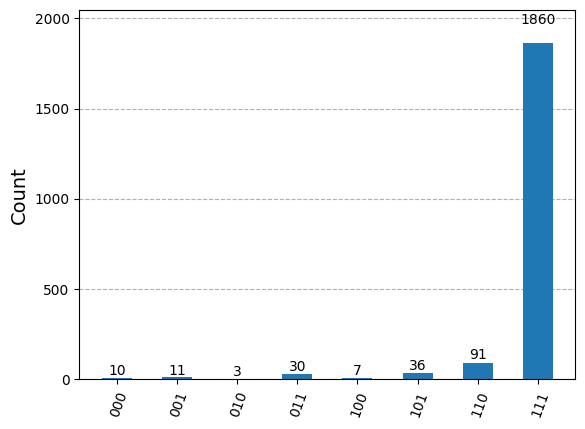

In [31]:
plot_histogram(counts)

# Caso constante

Usando el backend: ibm_kyiv


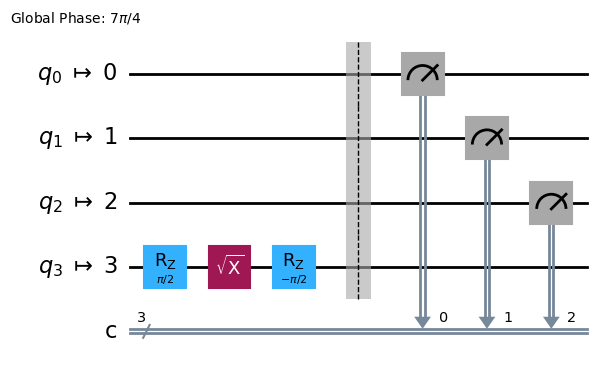

In [24]:
# Numero de bits de entrada
n = 3

# Creamos los registros cuánticos y clásicos
qr = QuantumRegister(n+1, 'q')
cr = ClassicalRegister(n, 'c')

# Paso 1 : Preparar el estado inicial
qc = QuantumCircuit(qr, cr)
qc.h(range(n))      # Aplicar H a los qubits de entrada
qc.x(n)             # Aplicar X al qubit auxiliar
qc.h(n)             # Aplicar H al qubit auxiliar

# Paso 2: Aplicar el oráculo
oracle_gate = deutsch_jozsa_oracle(nbits=n, f_type="constant", constant_value=0)
qc.append(oracle_gate, qr)

# Paso 3: Aplicar H a los qubits de entrada
qc.h(range(n))
qc.barrier()

# Paso 4: Medir los qubits de entrada
qc.measure(range(n), range(n))

# definimos el backend
backend = service.least_busy(simulator= False, operational=True)

# convertimos el circuito en un circuito de instrucciones de lenguaje intermedio

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
print(f"Usando el backend: {backend.name}")
isa_circuit = pm.run(qc)
isa_circuit.draw("mpl", idle_wires=False)

In [25]:
job = backend.run(isa_circuit, shots=2048)
# Recuperar los resultados
print(f">>> Job ID: {job.job_id()}")


/tmp/ipykernel_81330/4253829938.py:1: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  job = backend.run(isa_circuit, shots=2048)


>>> Job ID: cxbyz6ctpsjg008kzfd0


In [ ]:
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='******************'
)
job = service.job('cxbyz6ctpsjg008kzfd0')
job_result = job.result()

# Mostrar el histograma con los resultados  
counts = job_result.get_counts()

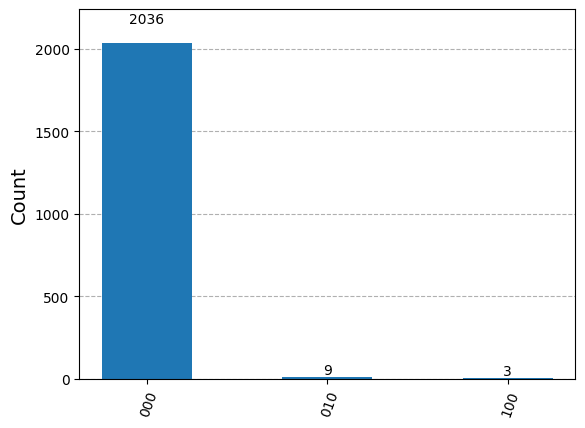

In [27]:
plot_histogram(counts)